### 方法

#### 权重衰减等价于 $L_2$ 范数正则化。正则化通过为模型损失函数添加惩罚使学出的模型参数值较小，是应对过拟合的常用手段，我们先描述$L_2$范数正则化，再解释它为何又称权重衰减
#### $L_2$范数正则化在模型原损失函数的基础上添加$L_2$范数惩罚项，从而得到训练所需要的最小化的函数。$L_2$范数惩罚项指的是模型权重参数每个元素的平方和一个正的常数的乘积

### 高维线性回归实验

In [1]:
import torch
import torch.nn as nn
import numpy as np 
import d2lzh_pytorch as d2l

n_train,n_test,num_inputs = 20,100,200
true_w,true_b = torch.ones(num_inputs,1)*0.01,0.05
features = torch.randn((n_train + n_test,num_inputs))
labels = torch.matmul(features,true_w)+true_b
labels += torch.tensor(np.random.normal(0,0.01,size = labels.size()),dtype = torch.float)
train_features,test_features = features[:n_train,:],features[n_train:,:]
train_labels,test_labels = labels[:n_train],labels[n_train:]

### 从零开始实现

### 初始化模型参数

#### 首先，定义随机初始化模型参数的函数。该函数为每个参数都附上梯度

In [2]:
def init_params():
    w = torch.randn((num_inputs,1),requires_grad = True)
    b = torch.zeros(1,requires_grad = True)
    return [w,b]


### 定义L2范数惩罚项

#### 下面定义L2范数惩罚项，这里只惩罚模型的权重参数

In [3]:
def l2_penalty(w):
    return(w**2).sum() / 2

### 定义训练和测试

#### 下面定义如何在训练数据集和测试数据集上分别训练和测试模型。与前几节不同的是，这里在计算最终的损失函数时添加了L2范数惩罚项

In [4]:
batch_size,num_epochs,lr = 1,100,0.003
net,loss = d2l.linreg,d2l.squared_loss

dataset = torch.utils.data.TensorDataset(train_features,train_labels)
train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle = True)

def fit_and_plot(lambd):
    w,b = init_params()
    train_ls,test_ls = [],[]
    for _ in  range(num_epochs):
        for X,y in train_iter:
            #添加了L2范数惩罚项
            l = loss(net(X,w,b),y) + lambd * l2_penalty(w)
            l = l.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
                
            l.backward()
            d2l.sgd([w,b],lr,batch_size)
        train_ls.append(loss(net(train_features,w,b),train_labels).mean().item())
        test_ls.append(loss(net(test_features,w,b),test_labels).mean().item())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

L2 norm of w: 13.732684135437012


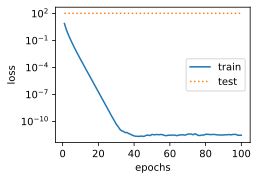

In [5]:
fit_and_plot(lambd = 0)

In [ ]:
#使用权重衰减

#### 下面使用权重衰减，可以看出，训练误差虽然有所提高，但测试集上的误差有所下降。过拟合现象得到一定程度的缓解，另外，权重参数的L2范数比不使用权重衰减时更小 ，此时的权重参数接近0

L2 norm of w: 0.03027508594095707


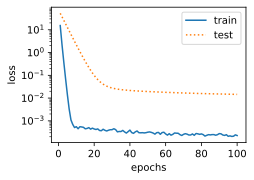

In [6]:
fit_and_plot(lambd = 3)

### 简洁实现

#### 这里我们直接在构造优化器实例时通过weight_decay参数来指定权重衰减超参数。默认下，pytorch会对权重和偏差同时衰减。我们可以分别对权重和偏差构造优化器实例。从而只对权重衰减

In [9]:
def fit_and_plot_pytorch(wd):
    #对权重参数衰减，权重名称一般是以weight结尾
    net = nn.Linear(num_inputs,1)
    nn.init.normal_(net.weight,mean=0,std=1)
    nn.init.normal_(net.bias,mean=0,std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight],lr = lr,weight_decay = wd)#对权重参数衰减
    optimizer_b = torch.optim.SGD(params = [net.bias],lr = lr)#不对偏差参数衰减
    
    train_ls,test_ls = [],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X),y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            
            l.backward()
            
            #对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
            
        train_ls.append(loss(net(train_features),train_labels).mean().item())
        test_ls.append(loss(net(test_features),test_labels).mean().item())
        
    d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','loss',
                range(1,num_epochs+1),test_ls,['train','test'])
    print('L2 norm of w:',net.weight.data.norm().item())
                   

L2 norm of w: 14.24246883392334


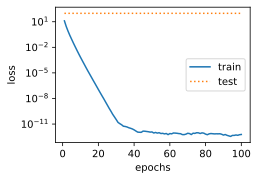

In [10]:
fit_and_plot_pytorch(0)

L2 norm of w: 0.03131529688835144


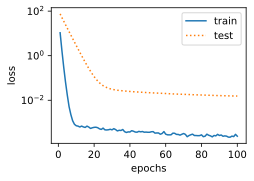

In [11]:
fit_and_plot_pytorch(3)

#### 正则化通过为模型损失函数添加惩罚使学出的模型参数更小，是应对过拟合的常用手段
#### 权重衰减等价于L2范数正则化，通常会使学到的权重参数的元素较接近0
#### 权重衰减可以通过优化器中的weight_decay超参数来指定
#### 可以定义多个优化器实例对不同的模型参数使用不同的迭代方法